## Credit Card Default Detection

<hr>

### Objective
Use Supervised Learning to build a model that can predict if given credit card user will default next month

### Background Info

A credit card is used to borrow money from a bank to make purchases. Such loans are usually in small amounts and paid back on a short term basis. When a user cannot pay back their loans it is considered a default. 

In this context, it is important for banks to know how many people, and who is likely to default so that they can optimise their finances and mitigate if possible. 

Therefore, for a bank that prioritises financial safety, it is important to identify those who will default correctly.

### The Dataset
| Feature                    | Description                                                                                     |
|----------------------------|-------------------------------------------------------------------------------------------------|
| Customer ID                | Unique customer identifier ranging from 1 to 1600                                                |
| Credit Limit               | The credit limit for the customer                                                               |
| Gender                     | Customer gender                                                                                 |
| Education                  | Customer education level                                                                        |
| Marriage Status            | Customer marital status                                                                         |
| Age                        | Rotational Customer age                                                                         |
| Bill_Amount1               | Customer credit card bill amount 1 month ago                                                     |
| Bill_Amount2               | Customer credit card bill amount 2 months ago                                                    |
| Bill_Amount3               | Customer credit card bill amount 3 months ago                                                    |
| Pay_Amount1                | The amount customer paid 1 month ago                                                             |
| Pay_Amount2                | The amount customer paid 2 months ago                                                            |
| Pay_Amount3                | The amount customer paid 3 months ago                                                            |
| Default payment next month | Whether the customer will default next month |

Total Rows: 1600
Features: 12

Target: Default payment next month: 1 means default (customer will not pay the bill), 0 means non-default (customer will pay the bill)

Features: Remaining columns

In [106]:
# Fundamentals
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import (
    StandardScaler, KBinsDiscretizer, 
    FunctionTransformer, OrdinalEncoder)
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline as Pipeline2

# Models
from sklearn.ensemble import( RandomForestClassifier, ExtraTreesClassifier,
                             HistGradientBoostingClassifier,
                             GradientBoostingClassifier, AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

# Tuning
from sklearn.model_selection import GridSearchCV

# Metrics and Others
from sklearn.model_selection import cross_validate,learning_curve
from sklearn.metrics import (classification_report, balanced_accuracy_score,
                             recall_score, precision_score, 
                             f1_score, confusion_matrix)

### Exploratory Data Analysis

In [3]:
df = pd.read_csv("../ST1511 AIML-CA1-datasets/credit_dataset.csv")
print(df.isna().sum())
df.describe()

Customer ID                   0
Credit Limit                  0
Gender                        0
Education                     0
Marriage Status               0
Age                           0
Bill_Amount1                  0
Bill_Amount2                  0
Bill_Amount3                  0
Pay_Amount1                   0
Pay_Amount2                   0
Pay_Amount3                   0
Default payment next month    0
dtype: int64


,Customer ID,Credit Limit,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Default payment next month
count,1600.00000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000
mean,800.50000,166787.500000,35.224375,49263.408125,47726.644375,44531.051875,5547.646250,5230.494375,4451.610625,0.212500
std,462.02453,129944.635707,9.404550,72687.106917,71476.217397,67164.064239,14085.471957,15569.605419,12491.715387,0.409205
min,1.00000,10000.000000,21.000000,-14386.000000,-13543.000000,-9850.000000,0.000000,0.000000,0.000000,0.000000
25%,400.75000,50000.000000,28.000000,3138.000000,3288.250000,2321.500000,1000.000000,468.500000,226.500000,0.000000
50%,800.50000,140000.000000,34.000000,20320.500000,19769.500000,19332.500000,2176.500000,1904.000000,1313.500000,0.000000
75%,1200.25000,230000.000000,41.000000,61602.750000,59891.750000,53857.250000,5021.000000,4592.500000,4000.000000,0.000000
max,1600.00000,700000.000000,75.000000,507726.000000,509229.000000,499936.000000,239104.000000,285138.000000,222750.000000,1.000000


No null values found. All numeric columns except age have very large ranges.

#### Univariate Analysis

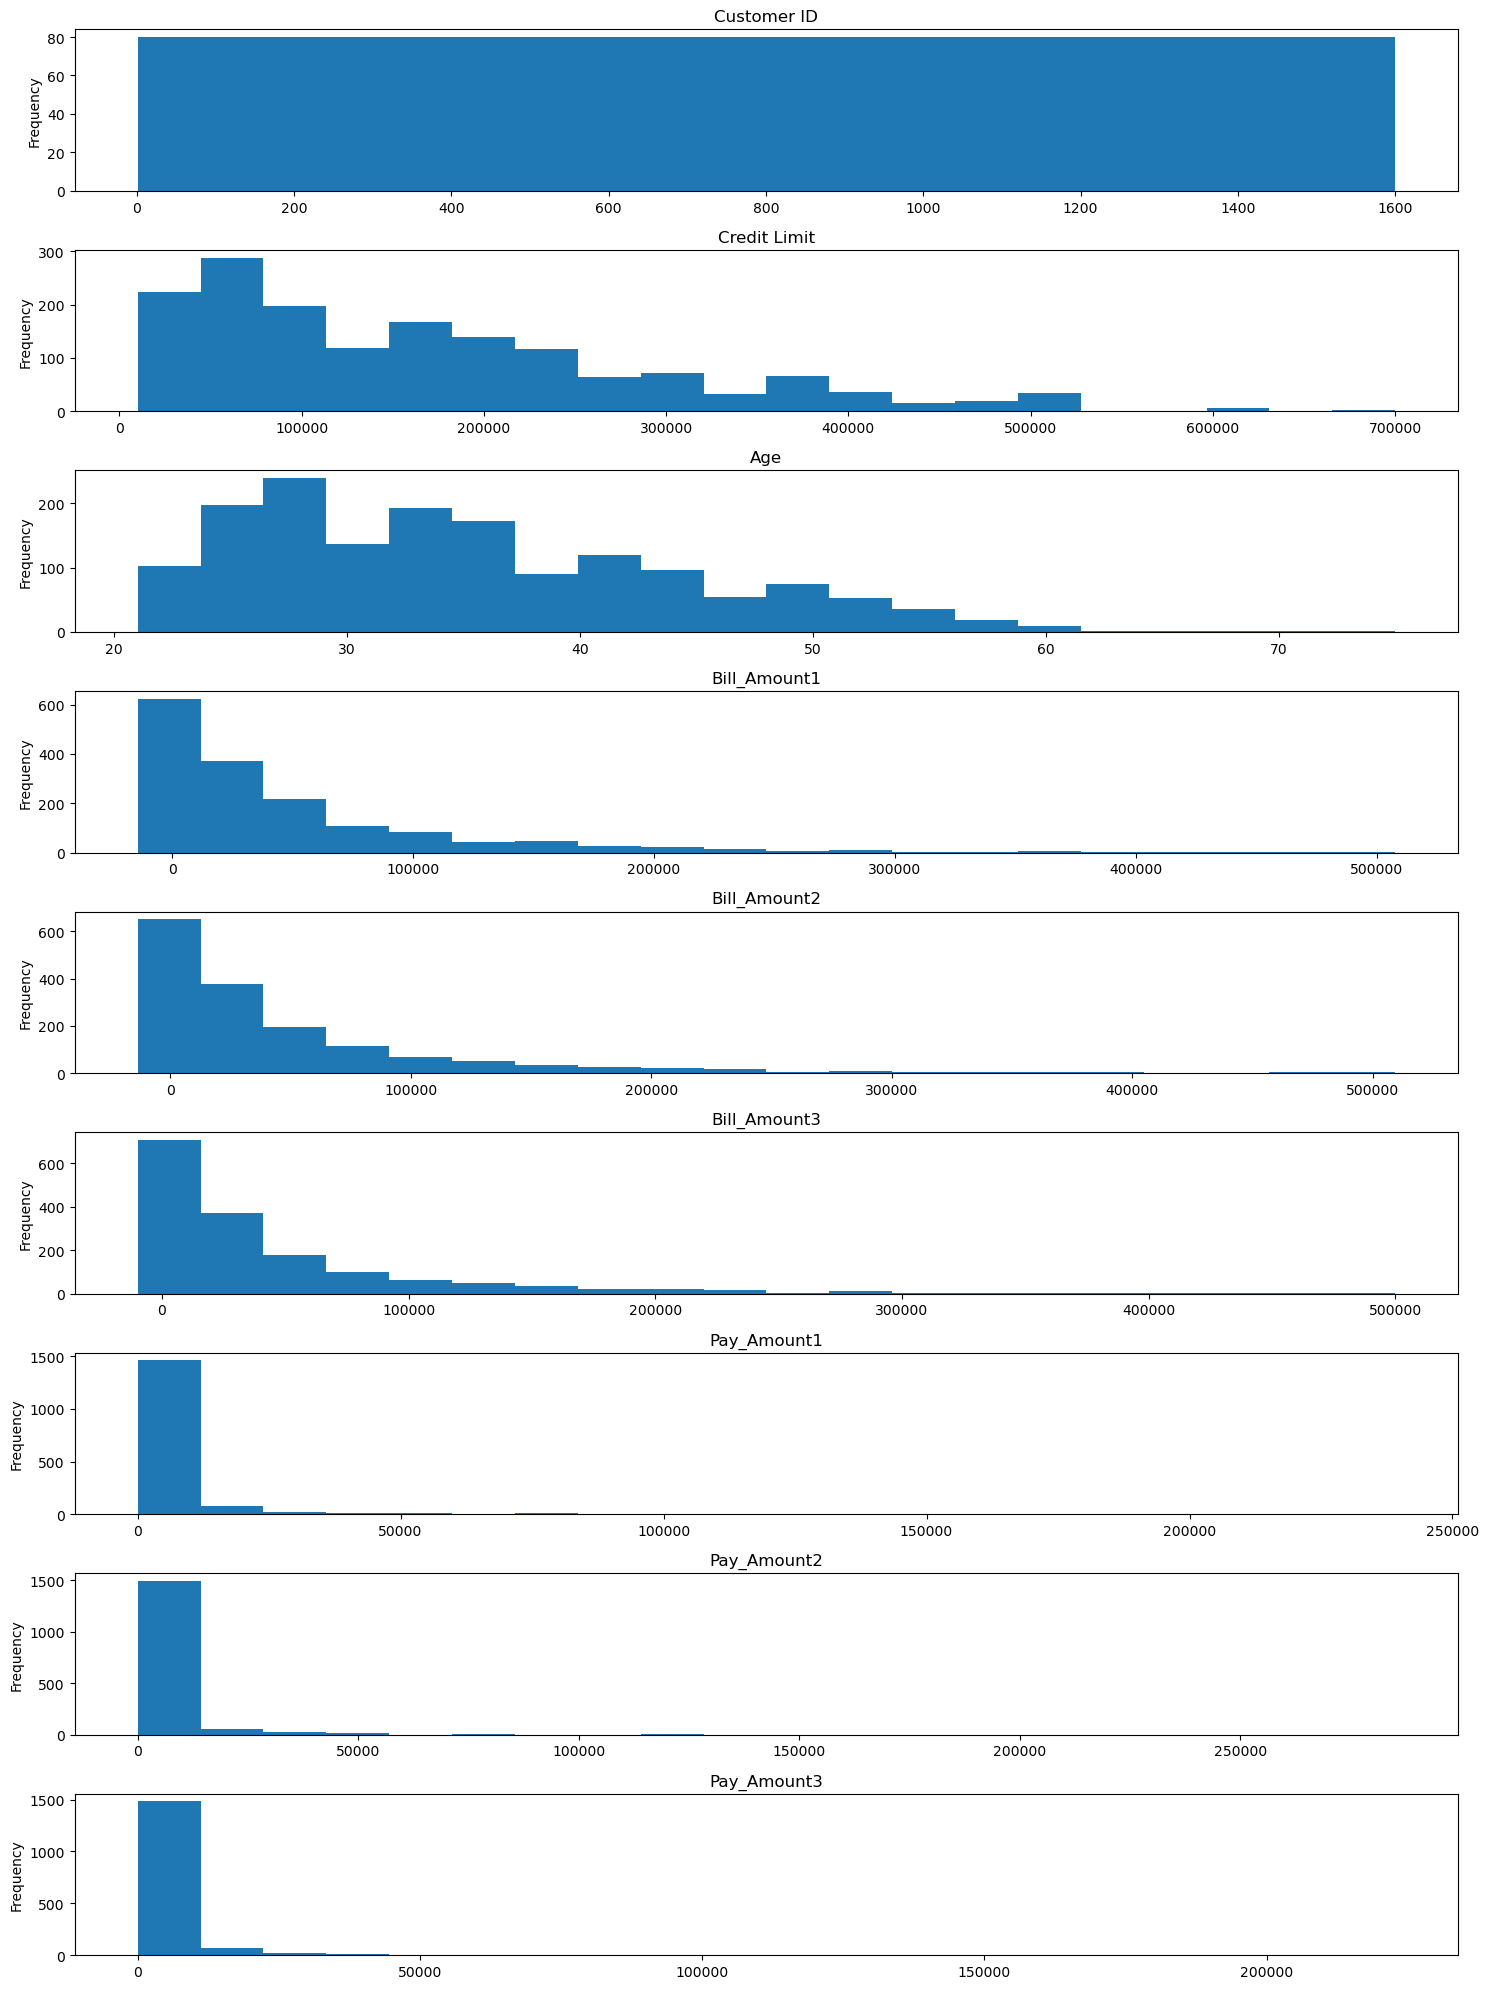

In [9]:
new_df = df.drop(columns=["Gender","Education","Marriage Status","Default payment next month"])
fig,ax = plt.subplots(len(new_df.columns),1,figsize=(15,20))

for i,col in enumerate(new_df.columns):
    ax[i].hist(new_df[col],bins=20)
    ax[i].set_title(col)
    ax[i].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

Customer_ID seems useless as its just a identifier. All numeric values are skewed to the right. Will need log transformations to fix them. Bill amounts have negative values as well so when log transformation I need to add a offset. Need to scale these numeric columns as well. 

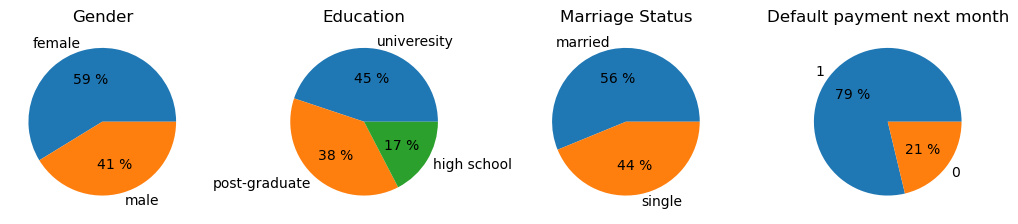

In [16]:
fig, ax = plt.subplots(1,4,figsize=(10,12))
ax[0].pie(df["Gender"].value_counts(),labels=df["Gender"].unique(), autopct="%.0f %%")
ax[0].set_title("Gender")
ax[1].pie(df["Education"].value_counts(),labels=df["Education"].unique(), autopct="%.0f %%")
ax[1].set_title("Education")
ax[2].pie(df["Marriage Status"].value_counts(),labels=df["Marriage Status"].unique(), autopct="%.0f %%")
ax[2].set_title("Marriage Status")
ax[3].pie(df["Default payment next month"].value_counts(),labels=df["Default payment next month"].unique(), autopct="%.0f %%")
ax[3].set_title("Default payment next month")
plt.tight_layout()
plt.show()

Categorical features look ok. High school seems to be rarer but not a huge problem. Target variable seems very imbalanced. To fix this later need to do oversampling or undersampling or both. 

### Bivariate Analysis

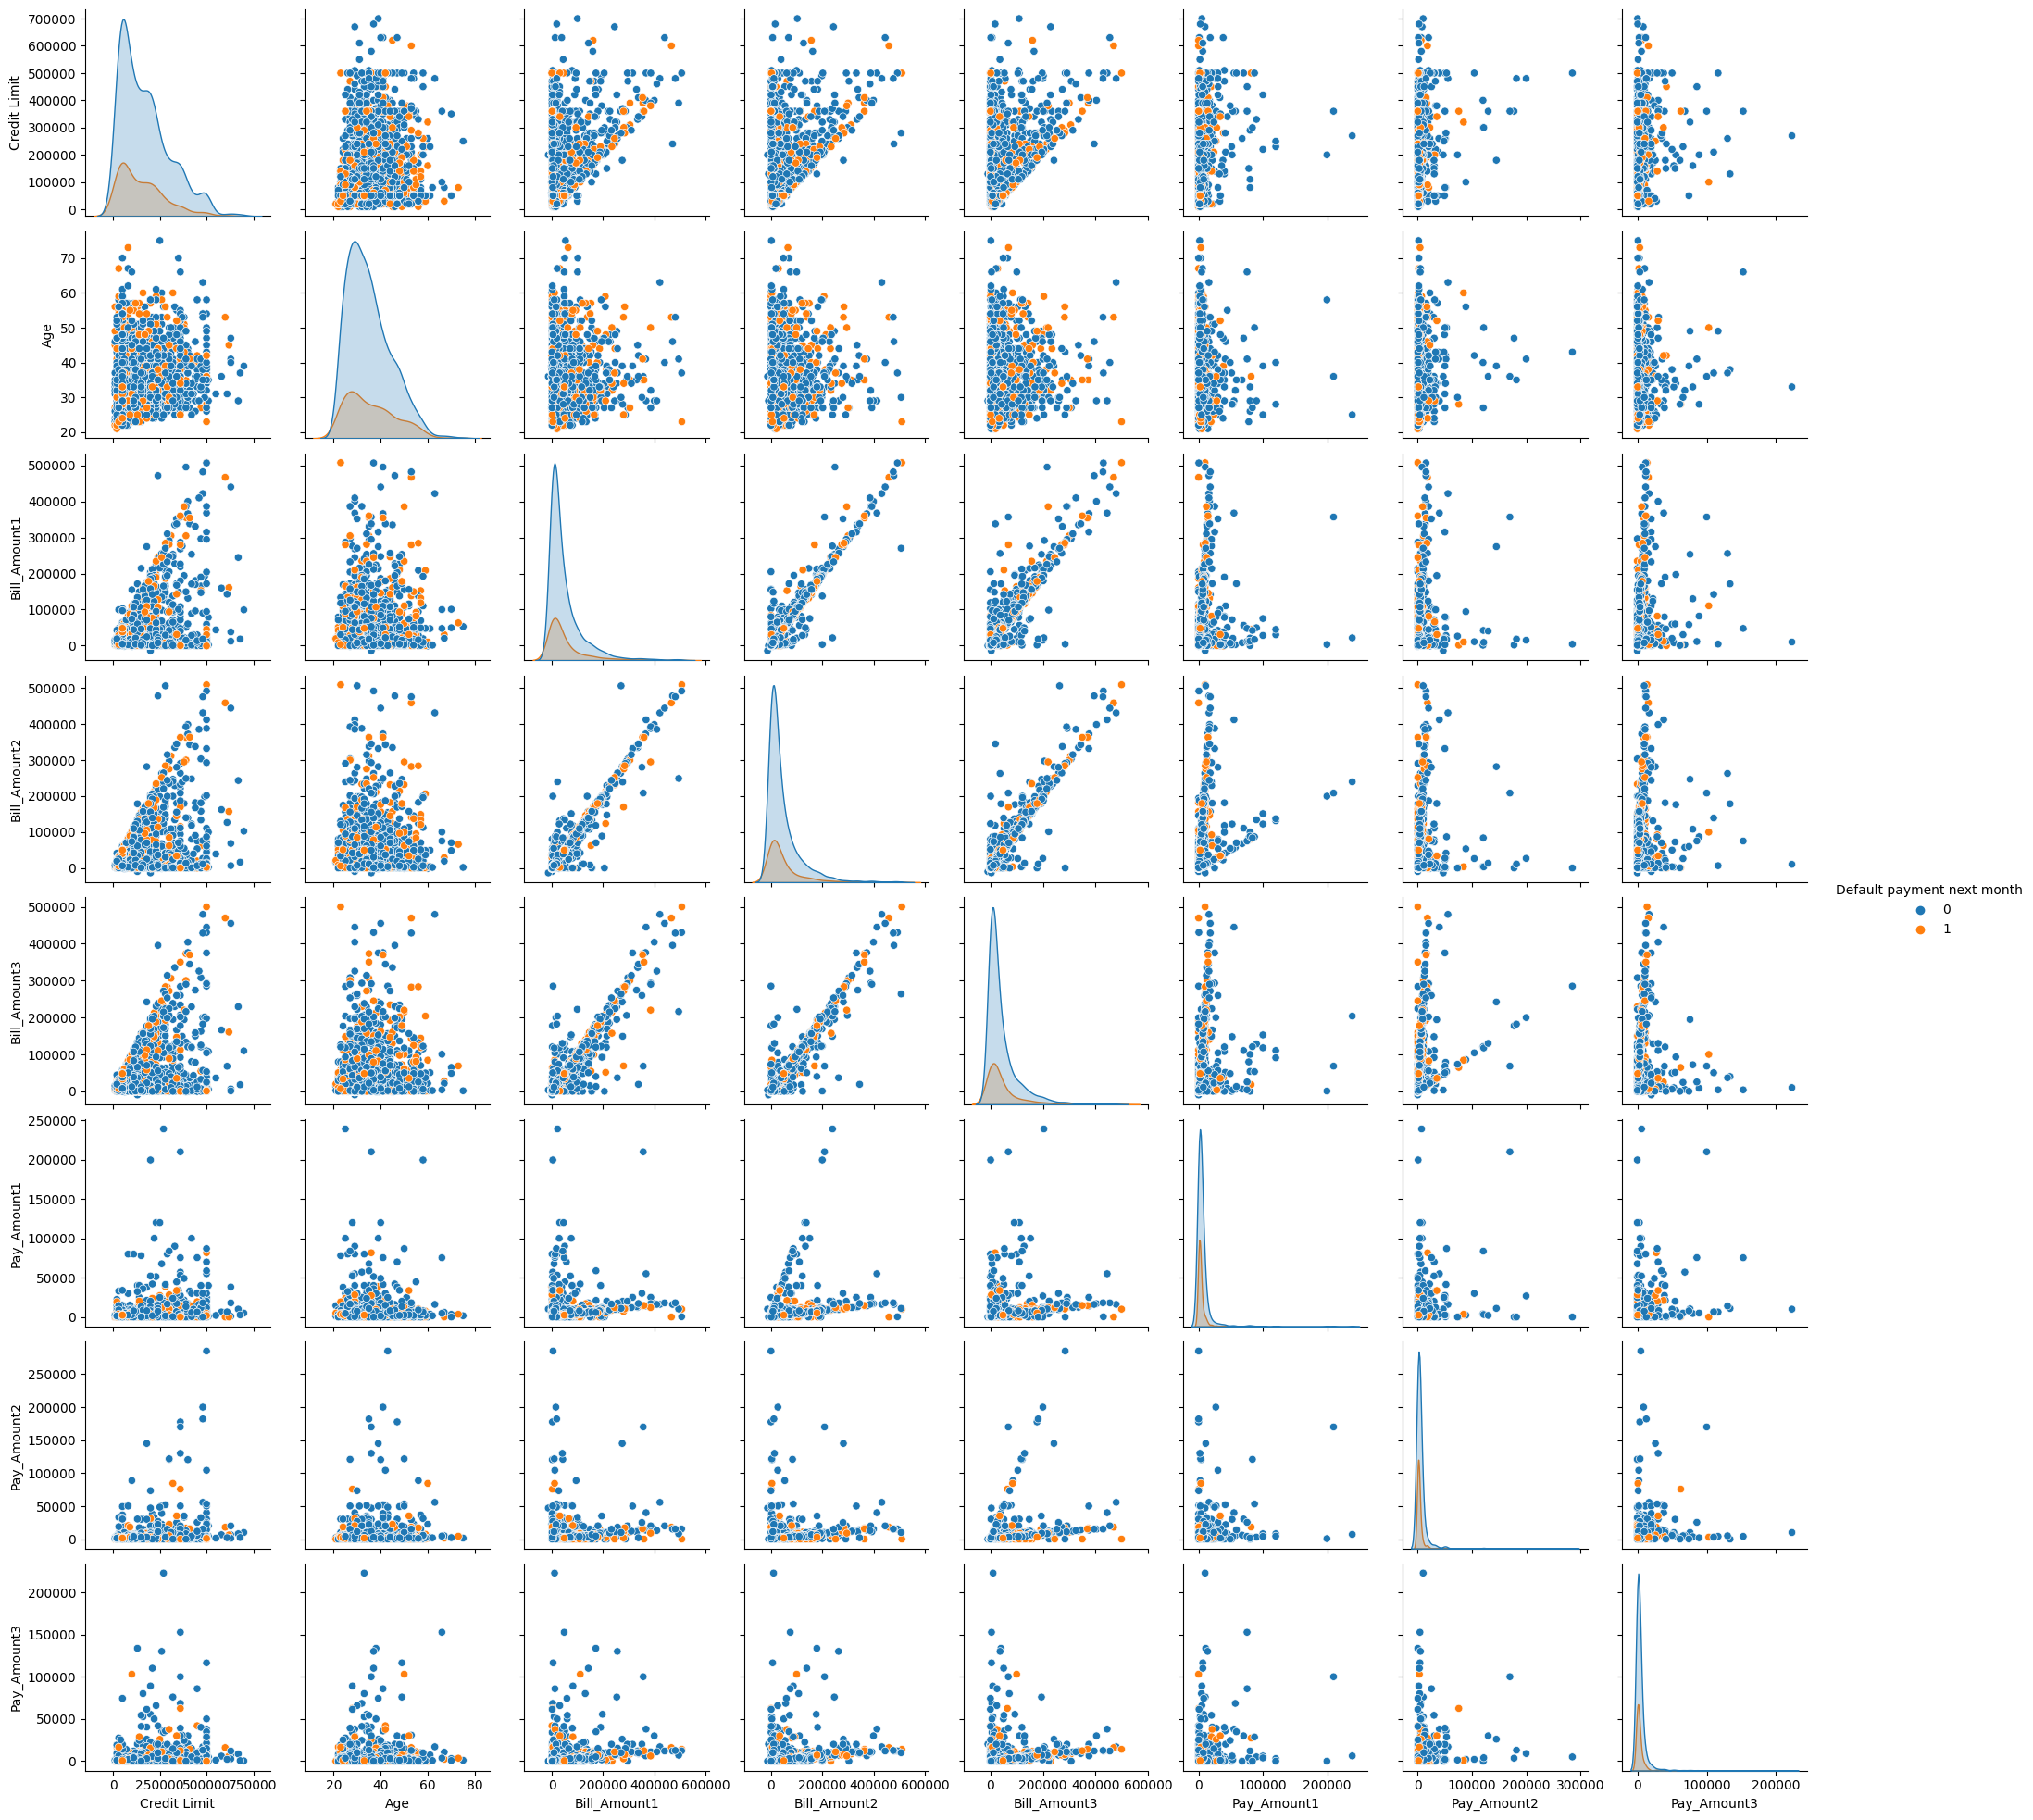

In [ ]:
sns.pairplot(df.drop(columns=["Customer ID"]),hue = "Default payment next month" )

It seems no two variables can say anything useful about the prediction since there is not clear trend. If you look at the histograms in the diagonal there doesnt seem to be a single variable that can explain the target too.

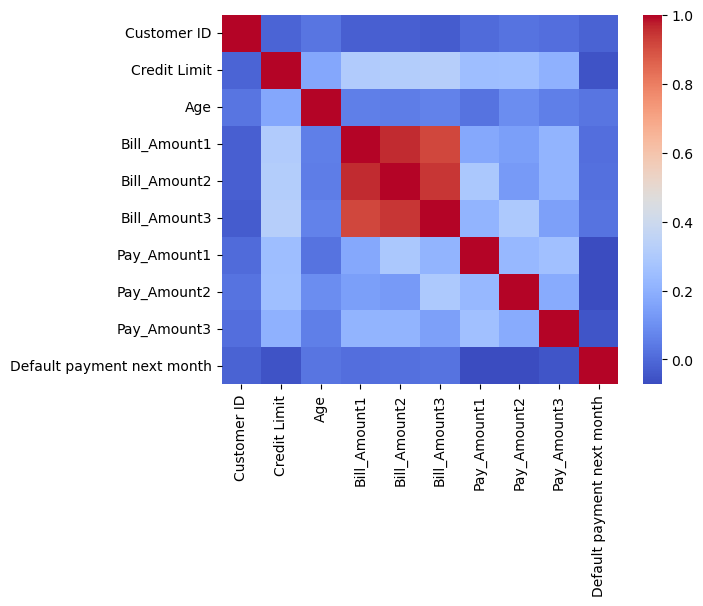

In [17]:
sns.heatmap(df.select_dtypes(include="number").corr(),cmap="coolwarm")
plt.show()

Bill amounts are correlated with each other the most. The rest not so much. There is possibility to do PCA for bill_amounts if data set takes too long to process

<Axes: xlabel='Age', ylabel='Count'>

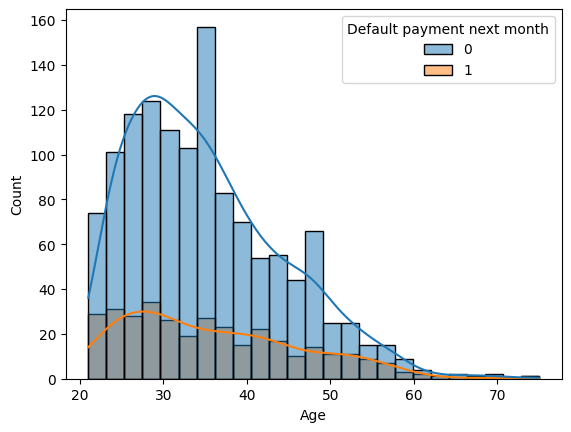

In [ ]:
sns.histplot(data=df,x="Age", hue="Default payment next month", kde = True)

Probability of Default seems to increase with Age as you can see after 50 there two lines become closer. The proportion of the two seems to be equal at the end. But maybe its not so clearcut


Summary

| Column         | Problem            | Transformation Needed     |
|----------------|--------------------|---------------------------|
| Customer ID    | Unnecessary        | Remove                    |
| Credit Limit, Bill and Pay amounts | Large scale/Skewed    | Log/Standardization   |
| Gender, Marriage | Nominal values     | One-hot encoding          |
| Education      | Ordinal            | Ordinal encoding          |
| Age            | Fine               | Standardisation (Optional)           |



### Feature Engineering

I can't do standardisation before splitting data cuz it might cause data leakage. The rest can do outside the pipeline. 

#### Removing Customer ID

In [38]:
X = df.iloc[:,1:-1] # all expect target and cust id
y = df['Default payment next month']

#### Transform Categorical Values
I wanted to do this inside the pipeline but I want to do SMOTE on this so can't have categorical values. 

Ordinal and One-Hot Encoding

In [39]:
enc = OrdinalEncoder(categories=[['high school', 'univeresity', 'post-graduate']])
X["Education"]= enc.fit_transform(X["Education"].values.reshape(-1,1))
X["Education"] = X["Education"].astype(int)
# dont want decimal cuz smote might create data like 1.5 in this column
X = pd.get_dummies(X,columns=["Marriage Status",'Gender'])


#### Add New Features
I want to create a feature call credit utitilisation. It is basically the extent to which a customer has used their maximum loan amount at a given month. I do this but subtracting the amount paid so far from the bill amount so far and then devide by the credit limit.

Credit Utilisation = $ \frac{{\ Amt. Borrowed So far - Amt. Paid So Far}}{Credit Limit} $

In [56]:
X['credit_util1'] = (X['Bill_Amount1']-X['Pay_Amount1']) / X['Credit Limit']
X['credit_util2'] = ((X['Bill_Amount1'] + X['Bill_Amount2'])-(X['Pay_Amount1'] + X['Pay_Amount2']) ) / X['Credit Limit']
X['credit_util3'] = ((X['Bill_Amount1'] + X['Bill_Amount2'] + X['Bill_Amount3'])-(X['Pay_Amount1'] + X['Pay_Amount2'] + X['Pay_Amount3'])) / X['Credit Limit']
X


,Credit Limit,Education,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Marriage Status_married,Marriage Status_single,Gender_female,Gender_male,credit_util1,credit_util2,credit_util3
0,20000,1,24,3913,3102,689,0,689,0,1,0,1,0,0.195650,0.316300,0.350750
1,120000,1,26,2682,1725,2682,0,1000,1000,0,1,1,0,0.022350,0.028392,0.042408
2,90000,1,34,29239,14027,13559,1518,1500,1000,0,1,1,0,0.308011,0.447200,0.586744
3,50000,1,37,46990,48233,49291,2000,2019,1200,1,0,1,0,0.899800,1.824080,2.785900
4,50000,1,57,8617,5670,35835,2000,36681,10000,1,0,0,1,0.132340,-0.487880,0.028820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,480000,1,35,18214,11031,182123,0,182123,12960,1,0,1,0,0.037946,-0.318496,0.033927
1596,150000,1,37,1184,794,2756,0,2772,0,1,0,1,0,0.007893,-0.005293,0.013080
1597,110000,2,29,107195,109443,106637,7845,4000,4000,0,1,1,0,0.903182,1.861755,2.794818
1598,240000,2,30,7744,7284,11234,7305,11263,10018,0,1,0,1,0.001829,-0.014750,-0.009683


#### Split Data
I will use a 80-20 split as it is most common. I will stratify y to ensure balance in the test data


In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42, stratify=y)


### Model Selection
I will compare 12 models commonly used for classification and compare their scores and then pick a few promising ones and further investigate their learning curves to detect overfitting or underfitting. 

![confusion](https://www.researchgate.net/publication/330174519/figure/fig1/AS:711883078258689@1546737560677/Confusion-matrix-Exemplified-CM-with-the-formulas-of-precision-PR-recall-RE.png)
#### Metrics:
- Accuracy: How correctly the model classfies data
- Balanced Accuracy: It is $ \frac{{\frac{{TP}}{{TP+FN}} + \frac{{TN}}{{TN+FP}}}}{2} $
This will account for the imbalance in target values in the test data.
- Recall: Out of the customers it predicts "not default" how many are true
- Precision: Out of the customers it predicts "default" how many are true
- F1: Combination of Precision and Recall
- AUC_ROC: This shows how well the models differentiate the class

For this project, I will focus on recall to select my model as the bank would rather the model signal a good customer to be bad than a bad customer to be good. This is because I assume the bank is focusing on financial safety. I assume here that the cost of False Positives is lower than False Negatives.

For the final scoring, I will include Balanced Accuracy as the test data is imbalanced

### Create Pipeline Function 
As said above, I am doing log transformation to solve the skewness and standard scaler to make it easier for machines in my pipeline. 
I will also discretise the age to slightly reduce the noise in the data
I am using the Pipeline from imblearn as SMOTE doesn't work with sklearn pipeline as it doesnt have fit_transform method

In [76]:

def pipes(name,model):
  smt = SMOTE(random_state=42)
  pipy = Pipeline2([
    ("preprocessing", 
        ColumnTransformer([
                        ("num",FunctionTransformer(lambda x: np.log(x.astype(int)+15000)),[0,5,6,7]),
                        ("num2",FunctionTransformer(lambda x: np.log(x.astype(int)+1)),[0,8,9,10]),
                        ("scale",StandardScaler(),[0,4,5,6,7,8,9,10]),
                        ("discrete",KBinsDiscretizer(n_bins=5,encode="ordinal"),[4])
                        ])),
        ("smote",smt),
        (name,model)
    ])
  return pipy

#### Models
I will use the following models to compare initially. They have been given commonly used params.

In [77]:
models = [
    ("DummyClassifier", DummyClassifier(strategy="stratified")),
    ("AdaBoost", AdaBoostClassifier(n_estimators=50, learning_rate=1.0)),
    ("DecisionTreeClassifier", DecisionTreeClassifier(max_depth=None, min_samples_split=2)),
    ("ExtraTreesClassifier", ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2)),
    ("GradientBoostingClassifier", GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)),
    ("HistGradientBoostingClassifier", HistGradientBoostingClassifier( max_iter=100)),
    ("KNeighborsClassifier", KNeighborsClassifier(n_neighbors=5)),
    ("LogisticRegression", LogisticRegression(max_iter=1000)),
    ("NaiveBayes", GaussianNB()),
    ("Perceptron", Perceptron(max_iter=1000)),
    ("RandomForest", RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2)),
    ("Ridge", RidgeClassifier()),
    ("SVC", SVC())
]


### Model Selection
I will use cross validation on the train data to compare the models. This is because I don't want to touch the test data until the final scoring. Cross validation is quite thorough in testing the data.
First I will compute the various scores for the models. 

In [78]:
results = []
for name,model in models:
  pipe = pipes(name,model)
  skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) 
  score = cross_validate(pipe,X_train,y_train,cv=skf,scoring={
      'acc':"accuracy",
      'recall':'recall',
      'f1':'f1',
      'precision':'precision'
  })
  needed = { "name":name,
            "accuracy":np.mean(score["test_acc"]),
            "recall":np.mean(score["test_recall"]),
            "precision":np.mean(score["test_precision"]),
            "f1":np.mean(score["test_f1"])}
  results.append(needed)
pd.DataFrame(results)

/home/ram/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ram/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,name,accuracy,recall,precision,f1
0,DummyClassifier,0.532031,0.544180,0.239160,0.332109
1,AdaBoost,0.624219,0.448280,0.272632,0.337159
2,DecisionTreeClassifier,0.637500,0.375000,0.255931,0.303610
3,ExtraTreesClassifier,0.711719,0.224339,0.278851,0.247385
4,GradientBoostingClassifier,0.681250,0.341667,0.292319,0.311495
5,HistGradientBoostingClassifier,0.710938,0.304762,0.319341,0.308488
6,KNeighborsClassifier,0.583594,0.473942,0.246921,0.324222
7,LogisticRegression,0.567969,0.620370,0.273072,0.378023
8,NaiveBayes,0.329688,0.896296,0.227075,0.362290
9,Perceptron,0.653125,0.318783,0.285852,0.188604


From these results, based on recall, I will pick the following models to further test:
- Logistic Regression
- Naive Bayes
- Ridge

The rest have very low recall scores, even lower than the dummy

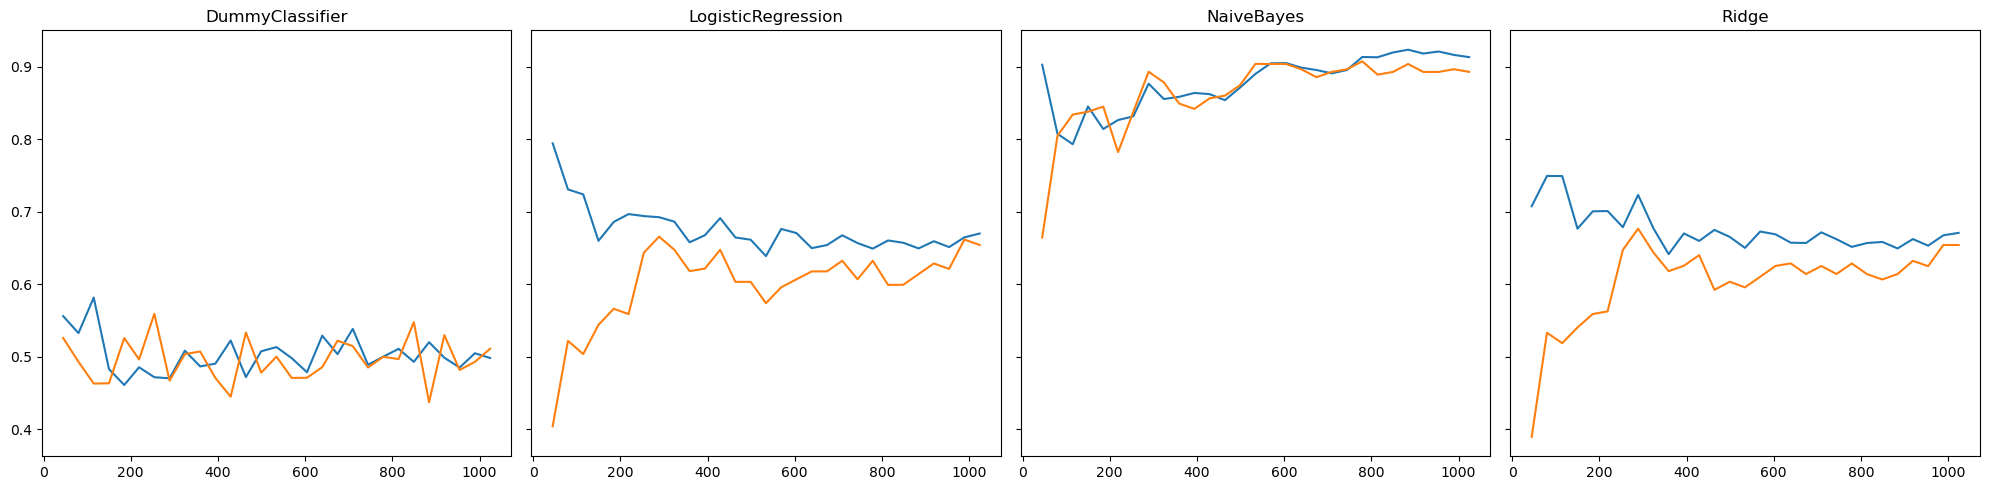

In [98]:
further_testing = [("DummyClassifier", DummyClassifier(strategy="stratified")),("LogisticRegression",LogisticRegression(max_iter=1000)),("NaiveBayes", GaussianNB()),("Ridge",RidgeClassifier())]
fig,ax=plt.subplots(1,4,figsize=(20,5),sharey=True)
for i, (name,model) in enumerate(further_testing):
  pipe = pipes(name,model)
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=99) 
  sizes, training_scores, testing_scores = learning_curve(estimator= pipe, X=X_train, y= y_train, cv=skf, scoring='recall', train_sizes=np.linspace(0.01, 1.0, 30))
  score_df = pd.DataFrame({"size":(sizes),"train":np.mean(training_scores,axis=1),"test":np.mean(testing_scores,axis=1)})
  ax[i].plot(score_df["size"],score_df["train"])
  ax[i].plot(score_df["size"],score_df["test"])
  ax[i].set_title(name)
plt.tight_layout()
plt.show()

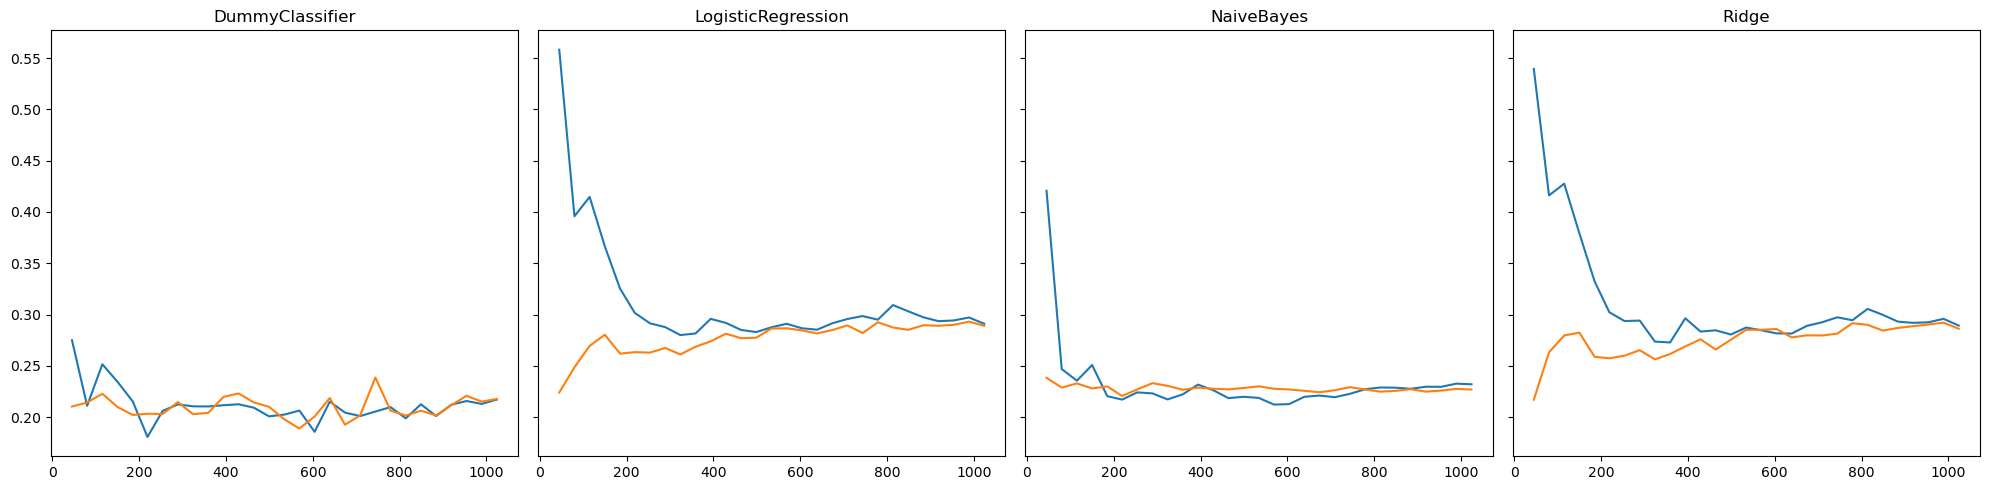

In [99]:
further_testing = [("DummyClassifier", DummyClassifier(strategy="stratified")),("LogisticRegression",LogisticRegression(max_iter=1000)),("NaiveBayes", GaussianNB()),("Ridge",RidgeClassifier())]
fig,ax=plt.subplots(1,4,figsize=(20,5),sharey=True)
for i, (name,model) in enumerate(further_testing):
  pipe = pipes(name,model)
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=99) 
  sizes, training_scores, testing_scores = learning_curve(estimator= pipe, X=X_train, y= y_train, cv=skf, scoring='precision', train_sizes=np.linspace(0.01, 1.0, 30))
  score_df = pd.DataFrame({"size":(sizes),"train":np.mean(training_scores,axis=1),"test":np.mean(testing_scores,axis=1)})
  ax[i].plot(score_df["size"],score_df["train"])
  ax[i].plot(score_df["size"],score_df["test"])
  ax[i].set_title(name)
plt.tight_layout()
plt.show()

We will ignore the first part of the curve as data is quite sparse and model can be unpredictable. We can see that all these models have high recall but low precision. Meaning, the model is good at finding who is not going to default but since their precision is low they can't distinguish those that are going to default. 

Naive Bayes doesn't improve its precision even when more data is added. The same can be said for the other two. 

Usually in machine learning there is a trade off between precision and recall. In this context, since I assume recall to be more important, i will choose Naive Bayes and go with it even though its precision might be low.

### First Evaluation

In [111]:
pipe = pipes("NaiveBayes",GaussianNB())
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
print("Balanced Accuracy: ",balanced_accuracy_score(y_test,y_pred))
print("Precision: ",precision_score(y_test,y_pred))
print("F1: ",f1_score(y_test,y_pred))
print("Recall: ",recall_score(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))

Balanced Accuracy:  0.5332633053221288
Precision:  0.22545454545454546
F1:  0.36151603498542273
Recall:  0.9117647058823529
Confusion Matrix: 
 [[ 39 213]
 [  6  62]]


### Hyper Param Tuning
I want to find the most optimal hyper params. I want to do GridSearchCV on the model's key parameter. 

In [104]:
pipe = pipes("NaiveBayes",GaussianNB())
rand_search = GridSearchCV(estimator = pipe,param_grid={"NaiveBayes__var_smoothing":np.logspace(0,-9,200)} ,
                            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42), return_train_score=False,scoring="recall")
rand_search.fit(X_train, y_train)
print(rand_search.best_params_,"\n", rand_search.best_score_)


{'NaiveBayes__var_smoothing': 0.08214343584919426} 
 0.9481481481481481


Naive bayes maxes at recall of 94.8%



### Final Evaluation
I will compare all the common metrics (balanced accuracy instead of accuracy cuz data is imbalanced)

I will also examine the confusion matrix

In [110]:
pipe = pipes("Dummy",DummyClassifier(strategy="stratified"))
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
print("Balanced Accuracy: ",balanced_accuracy_score(y_test,y_pred))
print("Precision: ",precision_score(y_test,y_pred))
print("F1: ",f1_score(y_test,y_pred))
print("Recall: ",recall_score(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))

Balanced Accuracy:  0.530578898225957
Precision:  0.23376623376623376
F1:  0.32432432432432434
Recall:  0.5294117647058824
Confusion Matrix: 
 [[134 118]
 [ 32  36]]


In [112]:
y_pred = rand_search.best_estimator_.predict(X_test)
print("Balanced Accuracy: ",balanced_accuracy_score(y_test,y_pred))
print("Precision: ",precision_score(y_test,y_pred))
print("F1: ",f1_score(y_test,y_pred))
print("Recall: ",recall_score(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))

Balanced Accuracy:  0.5468020541549953
Precision:  0.22996515679442509
F1:  0.37183098591549296
Recall:  0.9705882352941176
Confusion Matrix: 
 [[ 31 221]
 [  2  66]]


In [108]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.15      0.26       252
           1       0.23      0.91      0.36        68

    accuracy                           0.32       320
   macro avg       0.55      0.53      0.31       320
weighted avg       0.73      0.32      0.28       320



From these finding I can conclude that Naive Bayes is the best at minimising False Negatives. This is a pessimistic model for the bank. If this model predicts someone is not going to default, he most probably won't so the banks don't need to worry as much for the people who this model gives a 0 for. For the people that this model flags, the bank needs to keep them on watch and keep their finances ready to deal with a default